## Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import pickle
warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
df = pd.read_csv('../Crash_data/clean_september.csv')

print(df.dtypes)

df.info()

Color       int64
Crash     float64
Day         int64
Hour        int64
Minute      int64
Second      int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50539 entries, 0 to 50538
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Color   50539 non-null  int64  
 1   Crash   50539 non-null  float64
 2   Day     50539 non-null  int64  
 3   Hour    50539 non-null  int64  
 4   Minute  50539 non-null  int64  
 5   Second  50539 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 2.3 MB


## New Features

In [5]:
# How many times the counter was above or below 2x in a row
reset_counter = df['Color'] != 1
df['Above_2x_row'] = df['Color'].cumsum()-df['Color'].cumsum().where(reset_counter).ffill().fillna(0).astype(int)

reset_counter = df['Color'] != 0
df['Below_2x_row'] = df['Color'].eq(False).cumsum()-df['Color'].eq(False).cumsum().where(reset_counter).ffill().fillna(0).astype(int)

df['Crash/Minute'] = df['Crash'] / df['Minute']

df.head(10)

,Color,Crash,Day,Hour,Minute,Second,Above_2x_row,Below_2x_row,Crash/Minute
0,0,1.94,30,23,59,42,0,1,0.032881
1,1,6.69,30,23,59,22,1,0,0.113390
2,0,1.36,30,23,58,42,0,1,0.023448
3,1,2.61,30,23,58,27,1,0,0.045000
4,1,8.90,30,23,58,2,2,0,0.153448
5,0,1.00,30,23,57,12,0,1,0.017544
6,1,4.28,30,23,57,2,1,0,0.075088
7,1,2.21,30,23,56,32,2,0,0.039464
8,0,1.22,30,23,56,7,0,1,0.021786
9,1,5.35,30,23,55,52,1,0,0.097273


The game starts 10 seconds after the last result and the dataset records when the game finished. So it's necessary to shift by 1 all Hour (and Above/Below 2x too), Minute and Second and subtract 10 seconds.

In [6]:
df['Time'] = pd.to_datetime(df['Hour'].astype(str) +':'+ df['Minute'].astype(str) +':'+ df['Second'].astype(str), format='%H:%M:%S') - timedelta(seconds=10)
df['Time'] = df['Time'].shift(1)

df['Above_2x_row'], df['Below_2x_row'] = df['Above_2x_row'].shift(1), df['Below_2x_row'].shift(1)

# Time difference, in seconds, of the last drawn
df['Difference'] = (df['Time'].shift(1) - df['Time']).dt.total_seconds().dropna().astype(int)

df = df.dropna()

df['Hour'], df['Minute'], df['Second'] = df['Time'].dt.strftime('%H').astype(int), df['Time'].dt.strftime('%M').astype(int), df['Time'].dt.strftime('%S').astype(int)

df = df.drop('Time', axis=1)

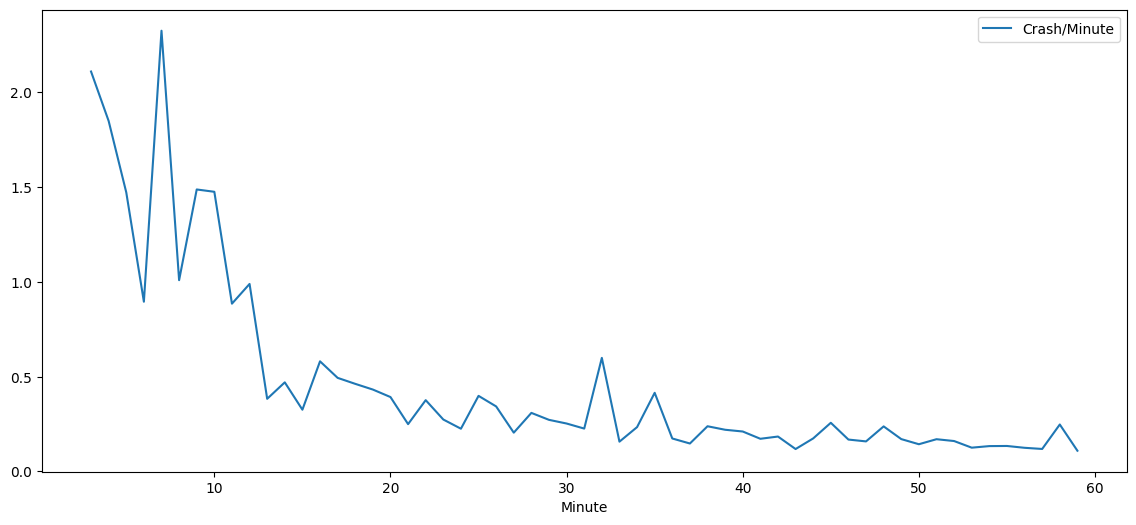

In [7]:
df.groupby('Minute').agg({'Crash/Minute':'mean'}).plot(figsize=(14,6));

Any anomaly detected. As in the beginning the number is smaller, it's normal to have bigger factors and a decrease as the minute (divisor) is bigger. There's a little anomaly in ~33 minute, but it's not a big deal.

The column will be drop as it's don't aggregate new information.

In [8]:
df = df.drop('Crash/Minute', axis=1)

Let's test if a simple analysis could be prpfitable in long term.

In [9]:
df.head()

,Color,Crash,Day,Hour,Minute,Second,Above_2x_row,Below_2x_row,Difference
2,0,1.36,30,23,59,12,1.0,0.0,20.0
3,1,2.61,30,23,58,32,0.0,1.0,40.0
4,1,8.90,30,23,58,17,1.0,0.0,15.0
5,0,1.00,30,23,57,52,2.0,0.0,25.0
6,1,4.28,30,23,57,2,0.0,1.0,50.0


In [10]:
def profit_or_loss(target:int=0) -> object:
    """
        This function receives a target (1x, 2x, 3x etc) and return the dataframe with the profit or loss
    """
    data_frame = df.copy()
    data_frame.loc[(data_frame.Crash >= target * 0.95)&(data_frame.Hour >= 9)&(data_frame.Hour <= 15), 'Profit'] = 1
    data_frame.loc[(data_frame.Crash <= target * 0.95)&(data_frame.Hour >= 9)&(data_frame.Hour <= 15), 'Profit'] = 0

    data_frame = data_frame.dropna()

    return data_frame

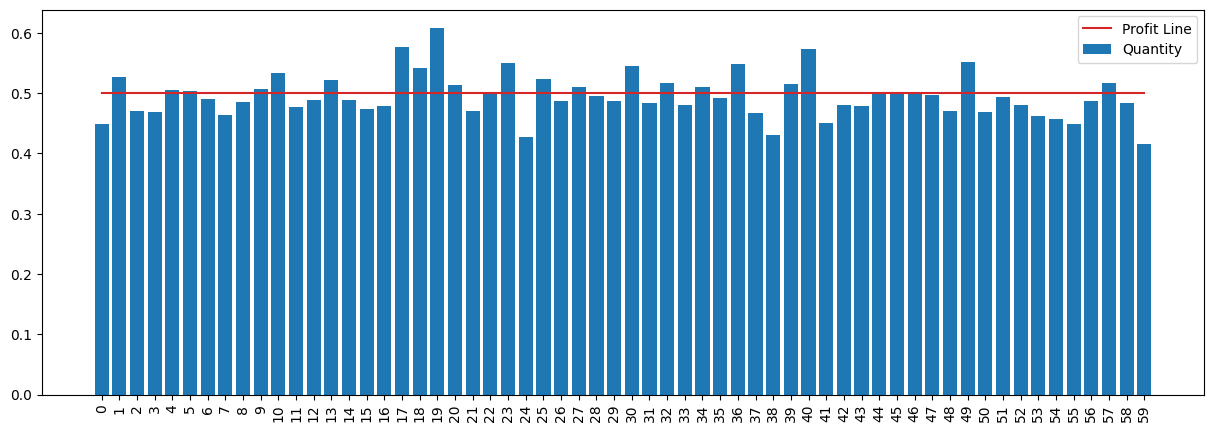

In [11]:
target = 2 # 2x target
teste = profit_or_loss(target=target)
teste = teste.groupby('Minute')['Profit'].sum() / teste.groupby('Minute')['Profit'].count()

plt.figure(figsize=(15,5))
plt.bar(teste.index, teste, color='tab:blue', label='Quantity')
plt.plot(teste.index, [1/target for n in range(min(teste.index), max(teste.index) + 1)], color='tab:red', label='Profit Line')
plt.xticks([n for n in range(60)], rotation=90)
plt.legend()
plt.show()

## Machine Learning

Can a simple algorithm predict when is a good ideia to bet?

Importing relevant modules

In [12]:
from scipy.stats import randint
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SKLearn CPU Accelerator

In [12]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
# Selecting the seed for future reproduction
SEED = 301
np.random.seed(SEED)

# Manipulating the first dataset
y1 = df['Crash'] # Regressor
y2 = df['Color']  # Clissifier

x = df[['Day', 'Hour', 'Minute', 'Second', 'Above_2x_row', 'Below_2x_row', 'Difference']]

# Scaling the data
scaler = StandardScaler()
x = scaler.fit_transform(x)

## Baseline Classification

In [14]:
df.groupby('Color')['Color'].value_counts() / df.shape[0] * 100

Color  Color
0      0        53.214477
1      1        46.785523
Name: Color, dtype: float64

In [15]:
# Setting the parameters to search
params = {
    'n_estimators':randint(1, 100),
    'max_depth':randint(1, 32),
    'min_samples_split':randint(32, 128),
    'min_samples_leaf':randint(32, 128),
    'criterion':['gini', 'entropy'],
    'bootstrap':[True, False]
}

# Place it all together
search1 = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=params,
    cv=StratifiedKFold(n_splits=2, shuffle=True),
    n_iter=5,
    n_jobs=10
)

search1.fit(x, y2)
results = pd.DataFrame(search1.cv_results_)
print(search1.best_score_)
print(search1.best_estimator_)
results.head()

0.5321843415694053
RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=52,
                       n_estimators=49)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.476998,0.010980,0.191527,0.008594,False,gini,8,100,50,62,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.531086,0.526080,0.528583,0.002503,3
1,0.751226,0.007041,0.140108,0.014042,False,entropy,3,108,124,57,"{'bootstrap': False, 'criterion': 'entropy', '...",0.532154,0.532136,0.532145,0.000009,2
2,2.155186,0.028597,0.371308,0.004742,True,gini,15,62,56,95,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.523329,0.520184,0.521756,0.001573,5
3,0.692801,0.040757,0.141763,0.002059,True,gini,4,100,52,49,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.532114,0.532254,0.532184,0.000070,1
4,1.130607,0.005032,0.150928,0.006032,False,entropy,10,72,120,39,"{'bootstrap': False, 'criterion': 'entropy', '...",0.525743,0.523310,0.524527,0.001216,4


Best parameters: RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=52, n_estimators=49)

Accuracy: 53.22%

In [16]:
# Setting the parameters to search
params = {
    'booster':['gbtree', 'gblinear', 'dart'],
    'eta':[x / 100 for x in range(1, 21)],
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[1, 2, 4, 16, 32, 64, 128, 256, 512],
    'min_child_weight':[1, 2, 4, 16, 32, 64, 128, 256, 512],
    'gamma':[0.1, 0.2, 0.4, 0.16, 0.32, 0.64, 0.128, 0.256, 0.512],
    'subsample':[0.1, 0.2, 0.4, 0.8, 1],
    'colsample_bytree':[0.1, 0.2, 0.4, 0.8, 1],
    'objective':['binary:logistic', 'binary:logitraw'],
    'tree_method':['gpu_hist']
}

# Place it all together
search2 = RandomizedSearchCV(
    XGBClassifier(),
    param_distributions=params,
    cv=StratifiedKFold(n_splits=2, shuffle=True),
    n_iter=3,
)

search2.fit(x, y2)
results2 = pd.DataFrame(search2.cv_results_)
print(search2.best_score_, search2.best_estimator_)
results.head()

[17:49:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

[17:49:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

0.5262678510366653 XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.11, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.476998,0.010980,0.191527,0.008594,False,gini,8,100,50,62,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.531086,0.526080,0.528583,0.002503,3
1,0.751226,0.007041,0.140108,0.014042,False,entropy,3,108,124,57,"{'bootstrap': False, 'criterion': 'entropy', '...",0.532154,0.532136,0.532145,0.000009,2
2,2.155186,0.028597,0.371308,0.004742,True,gini,15,62,56,95,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.523329,0.520184,0.521756,0.001573,5
3,0.692801,0.040757,0.141763,0.002059,True,gini,4,100,52,49,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.532114,0.532254,0.532184,0.000070,1
4,1.130607,0.005032,0.150928,0.006032,False,entropy,10,72,120,39,"{'bootstrap': False, 'criterion': 'entropy', '...",0.525743,0.523310,0.524527,0.001216,4


In [3]:
df_test = pd.read_csv('../Crash_data/clean_october.csv')

reset_counter = df_test['Color'] != 1
df_test['Above_2x_row'] = df_test['Color'].cumsum()-df_test['Color'].cumsum().where(reset_counter).ffill().fillna(0).astype(int)

reset_counter = df_test['Color'] != 0
df_test['Below_2x_row'] = df_test['Color'].eq(False).cumsum()-df_test['Color'].eq(False).cumsum().where(reset_counter).ffill().fillna(0).astype(int)

df_test['Time'] = pd.to_datetime(df_test['Hour'].astype(str) +':'+ df_test['Minute'].astype(str) +':'+ df_test['Second'].astype(str), format='%H:%M:%S') - timedelta(seconds=10)
df_test['Time'] = df_test['Time'].shift(1)

df_test['Above_2x_row'], df_test['Below_2x_row'] = df_test['Above_2x_row'].shift(1), df_test['Below_2x_row'].shift(1)

# Time difference, in seconds, of the last drawn
df_test['Difference'] = (df_test['Time'].shift(1) - df_test['Time']).dt.total_seconds().dropna().astype(int)

df_test = df_test.dropna()

df_test['Hour'], df_test['Minute'], df_test['Second'] = df_test['Time'].dt.strftime('%H').astype(int), df_test['Time'].dt.strftime('%M').astype(int), df_test['Time'].dt.strftime('%S').astype(int)

df_test = df_test.drop('Time', axis=1)

df_test.head()

,Color,Crash,Day,Hour,Minute,Second,Above_2x_row,Below_2x_row,Difference
2,1,2.30,21,11,34,56,0.0,1.0,30.0
3,1,746.00,21,11,34,46,1.0,0.0,10.0
4,1,14.20,21,11,34,21,2.0,0.0,25.0
5,0,1.16,21,11,32,20,3.0,0.0,121.0
6,0,1.33,21,11,31,25,0.0,1.0,55.0


In [32]:
x_test = scaler.transform(df_test[['Day', 'Hour', 'Minute', 'Second', 'Above_2x_row', 'Below_2x_row', 'Difference']])
search_list = [search1, search2]

for search in search_list:
    predict = search.predict(x_test)

    df_test['Predict'] = predict

    right = df_test.loc[(df_test['Predict'] == df_test.Color)]['Color'].value_counts()
    wrong = df_test.loc[(df_test['Predict'] != df_test.Color)]['Color'].value_counts()

    accuracy = right / (right + wrong)

    print(search.best_estimator_)
    print(accuracy)

RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=52,
                       n_estimators=49)
0    0.999921
1    0.000459
Name: Color, dtype: float64
XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.11, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=512,
              max_leaves=None, min_child_weight=512, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)
0    0.854837
1    0.147070
Name: Color, dtype: float64


## Save the models

In [33]:
import pickle as cPickle

for key, search in enumerate(search_list):
    cPickle.dump(search.best_estimator_, open(f'search{key + 1}.pkl', 'wb'))

## Old Version

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler


# Load the dataset
df_oct = pd.read_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash_data\clean_october.csv')
df_oct = df_oct.drop(['Unnamed: 0'], axis=1)
df_oct.loc[df_oct['Cor'] == 'Good', ['Cor']] = 1
df_oct.loc[df_oct['Cor'] == 'Bad',  ['Cor']] = 0

df = pd.read_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash_data\clean_september.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.loc[df['Cor'] == 'Good', ['Cor']] = 1
df.loc[df['Cor'] == 'Bad',  ['Cor']] = 0


# Train-Test split
X_train, y_train, X_test, y_test = df.drop(['Crash', 'Cor'], axis=1), df[['Crash']], df_oct.drop(['Crash', 'Cor'], axis=1), df_oct[['Crash']]

# DecisionTree Model
decision_tree = ExtraTreesRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict values
y_pred = decision_tree.predict(X_test)

# Appeding values to y_test
y_test['Predict'] = y_pred
y_test = pd.concat([y_test, X_test], axis=1)

In [56]:
# Train-Test split
X_train, y_train, X_test, y_test2 = df.drop(['Crash', 'Cor', 'Day'], axis=1), df[['Cor']], df_oct.drop(['Crash', 'Cor', 'Day'], axis=1), df_oct[['Cor']]

for n in range(1, 7):
    X_train[f'Crash_{n}'] = df[['Crash']].shift(- n)
    X_test[f'Crash_{n}'] = df_oct[['Crash']].shift(- n)

X_train.dropna(inplace=True), X_test.dropna(inplace=True)
y_train.drop(y_train.tail(6).index, inplace=True), y_test2.drop(y_test2.tail(6).index, inplace=True)

# DecisionTree Model
decision_tree_cor = ExtraTreesRegressor(random_state=42)
decision_tree_cor.fit(X_train, y_train)

# Predict values
y_pred = decision_tree_cor.predict(X_test)

# Appeding values to y_test
y_test2['Cor_predict'] = y_pred
y_test2.loc[y_test2.Cor_predict >= 0.5, 'Cor_predict'] = 1
y_test2.loc[y_test2.Cor_predict <  0.5, 'Cor_predict'] = 0
y_test2 = pd.concat([y_test2, X_test], axis=1)

# All y_test together
y_test = pd.concat([y_test2[['Cor', 'Cor_predict']], y_test], axis=1)
y_test.dropna(inplace=True)

In [57]:
def profit_or_loss(crash, predict, minute):
    profit_factor = 1.5
    if crash > profit_factor and predict > profit_factor:
        return profit_factor * 100 - 100
    
    else:
        return -100
        
y_test['Profit'] = 0
y_test['Profit'] = y_test[['Crash', 'Predict', 'Minute']].apply(lambda row: profit_or_loss(row.Crash, row.Predict, row.Minute), axis=1)

y_test['Income'] = 0
for n in range(0, y_test.shape[0]):
    if n == 0:
        y_test.iloc[n, 9] = y_test.iloc[n, 8]
        
    y_test.iloc[n, 9] = y_test.iloc[n - 1, 9] + y_test.iloc[n, 8]

y_test['Cor'] = y_test['Cor'].astype('float64')

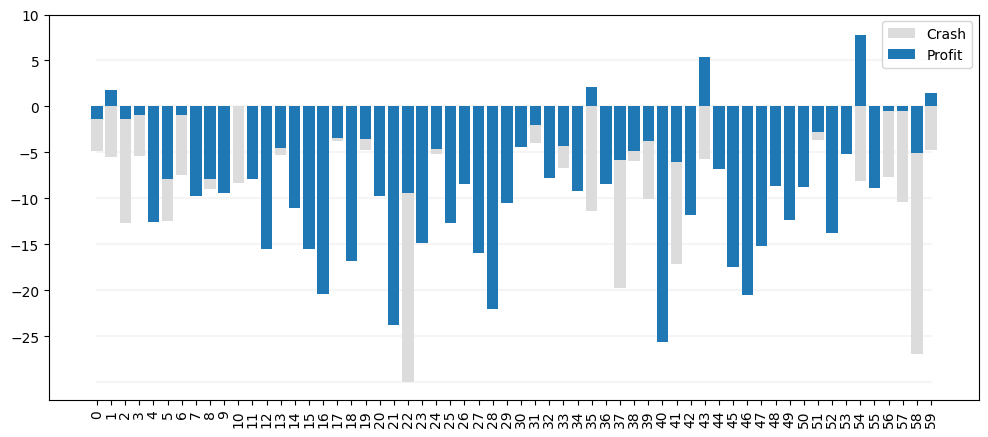

In [58]:
plt.figure(figsize=(12, 5))

teste = y_test.loc[(y_test2.Hour > 9)&(y_test2.Hour < 17), :].groupby(by='Minute').mean()
teste.loc[teste.Crash > 30, 'Crash'] = 30

for n in range(-1, 7):
    plt.plot([j for j in range(60)], [n * - 5 for j in range(60)], color='whitesmoke', zorder=1)

plt.bar(y_test.Minute.unique(), teste['Crash'] * - 1, color='gainsboro', label='Crash', zorder=2)
plt.bar(y_test.Minute.unique(), teste['Profit'], color='tab:blue', label='Profit', zorder=4)
plt.xticks([n for n in range(60)], rotation=90)
plt.yticks([n for n in range(10, -30, -5)])
plt.legend()
plt.show()

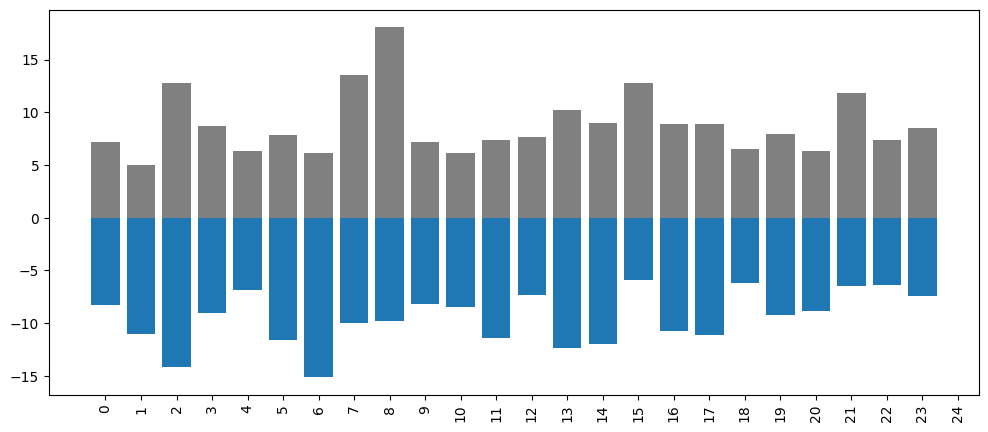

In [59]:
plt.figure(figsize=(12, 5))
plt.bar(y_test.Hour.unique(), y_test.groupby(by='Hour').mean()['Crash'], color='gray')
plt.bar(y_test.Hour.unique(), y_test.groupby(by='Hour').mean()['Profit'], color='tab:blue')
plt.xticks([n for n in range(0, 25)], rotation=90)
plt.show()

In [191]:
last_num = pd.DataFrame([[2.15, 1.00, 3.06, 6.20, 2.65]], columns=['C1', 'C2', 'C3', 'C4', 'C5'])
last_num.to_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash_data\actual.csv')

In [66]:
def prevendo(actual_num):
    dt = datetime.now() #+ timedelta(seconds=2)

    last_num_read = pd.read_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash_data\actual.csv')
    last_num_read.drop('Unnamed: 0', axis=1, inplace=True)

    last_num_read = pd.concat([last_num_read, pd.DataFrame([[actual_num]], columns=['C6'])], axis=1)

    time = pd.DataFrame([[dt.hour, dt.minute, dt.second]], columns=['Hour', 'Minute', 'Second'])

    last_num_read = pd.concat([time, last_num_read], axis=1)

    predict = round( decision_tree_cor.predict(last_num_read)[0], 0 )

    if predict > 0.9:
        print(actual_num, 'VERDEEEEE')

    else:
        print(actual_num, 'zzZz')

    for n in range(0, 5):
        last_num_read.iloc[:, 3 + n] = last_num_read.iloc[:, 4 + n]

    last_num_read.drop(['Hour', 'Minute', 'Second', 'C6'], axis=1, inplace=True)

    last_num_read.to_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash_data\actual.csv')

    print('\n\n', last_num_read)

In [246]:
actual_num = 1.38
prevendo(actual_num)

1.38 VERDEEEEE


      C1    C2    C3    C4    C5
0  2.08  2.56  1.23  1.07  1.38


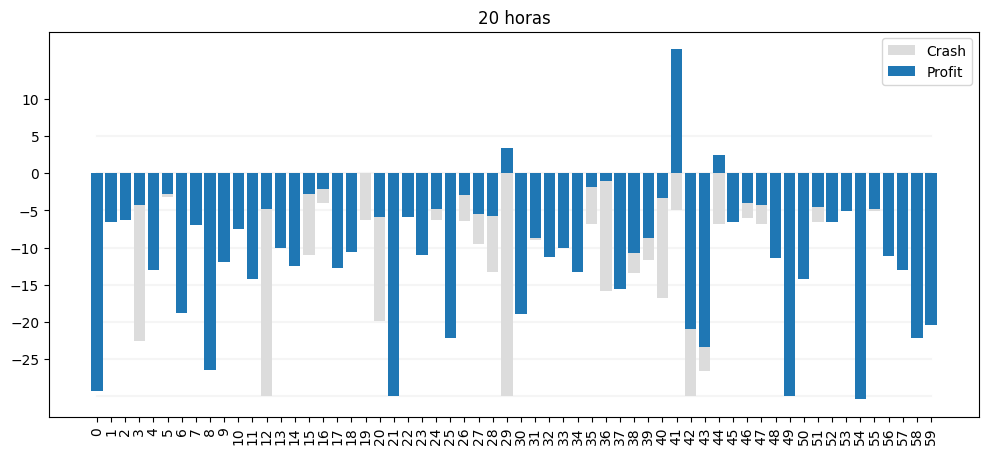

In [63]:
plt.figure(figsize=(12, 5))

teste = y_test.loc[(y_test2.Hour > 20), :].groupby(by='Minute').mean()
teste.loc[teste.Crash > 30, 'Crash'] = 30

for n in range(-1, 7):
    plt.plot([j for j in range(60)], [n * - 5 for j in range(60)], color='whitesmoke', zorder=1)

plt.bar(y_test.Minute.unique(), teste['Crash'] * - 1, color='gainsboro', label='Crash', zorder=2)
plt.bar(y_test.Minute.unique(), teste['Profit'], color='tab:blue', label='Profit', zorder=4)
plt.xticks([n for n in range(60)], rotation=90)
plt.yticks([n for n in range(10, -30, -5)])
plt.legend()
plt.title(f'20 horas')
plt.show()

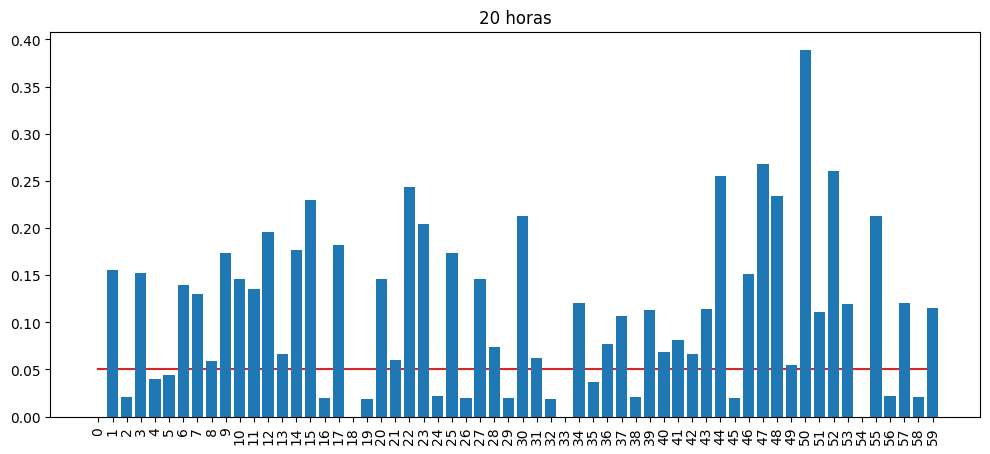

In [62]:
plt.figure(figsize=(12, 5))

teste = y_test.loc[(y_test2.Hour > 20), :].groupby(by='Minute').mean()
teste['Teste'] = abs(teste['Cor'] - teste['Cor_predict'])

plt.plot([n for n in range(0, 60)], [0.05 for n in range(60)], color='tab:red', zorder=1)
plt.bar(teste.index, teste['Teste'], color='tab:blue', label='Crash', zorder=2)

plt.xticks([n for n in range(60)], rotation=90)
plt.title(f'20 horas')
plt.show()

In [346]:
# path = r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\Crash\decision_tree_model.pkl'
# pickle.dump(decision_tree_cor, open(path, 'wb'))

# pickled_model = pickle.load(open(path, 'rb'))